##### Copyright 2018 Google LLC.

Licensed under the Apache License, Version 2.0 (the "License");

In [ ]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Cosine Similarity Overlays

Cosine similarity overlays are a simple interface for understanding what nerual networks consider similar and different. They were originally introduced by Alex Mordvintsev.




In [3]:
!pip install --quiet git+https://github.com/ercaronte/lucid.git
!npm install -g svelte-cli@2.2.0

In [4]:
import numpy as np
import tensorflow as tf
#tensorflow_version only works on colab
#%tensorflow_version 1.x
#assert tf.__version__.startswith('1')

import lucid.modelzoo.vision_models as models
import lucid.optvis.render as render
from lucid.misc.io import show, load
from lucid.misc.io.showing import _image_url
import lucid.scratch.web.svelte as lucid_svelte

In [8]:
googlenet = models.InceptionV1()
googlenet.load_graphdef()

def get_acts(layer, img):
  with tf.Graph().as_default(), tf.compat.v1.Session():
    t_input = tf.compat.v1.placeholder(tf.float32, [224, 224, 3])
    T = render.import_model(googlenet, t_input, t_input)
    acts = T(layer).eval({t_input: img})[0]
  return acts

def many_cossim(us,v):
  us_mags = np.sqrt((us*us).sum(-1)) + 1e-4
  v_mag = np.sqrt((v*v).sum()) + 1e-4
  return (us*v).sum(-1) / us_mags / v_mag

def cossim_grid(acts1, acts2):
  cossims = [[many_cossim(acts2, v)
   for v in row] for row in acts1]
  return np.asarray(cossims)

In [9]:
#img = load("https://storage.googleapis.com/lucid-static/building-blocks/examples/dog_cat.png")
img = load("https://github.com/ercaronte/lucid/raw/master/notebooks/static/dogcat.jpg")
acts = get_acts("mixed4d", img)
print(acts.shape)

(14, 14, 528)


2023-04-27 16:37:03.550360: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled
2023-04-27 16:37:03.556087: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


(14, 14, 14, 14)




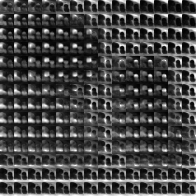

In [10]:
cossims = cossim_grid(acts, acts)
print(cossims.shape)
print("")
cossims_flat = np.hstack(np.hstack(cossims))
show(cossims_flat)

In [26]:
%%html_define_svelte CossimOverlay

<div class="container" style="width: {{size}}px; height: {{size}}px; ">
  <!--div class="image" style="background-image: url({{image_url}}); z-index: -10; width: {{size}}px; height: {{size}}px;"></div-->
  <div class="overlay" style="z-index: 10; width: {{size}}px; height: {{size}}px; left: {{size/2-N/2}}px; top:{{size/2-N/2}}px">
    <div class="image" style="background-image: url({{image_url}}); width: {{size}}px; height: {{size}}px; left:-{{size/2-N/2}}px; top:-{{size/2-N/2}}px"></div>
    <div class="overlay-inner" style="background-image: url({{masks_url}}); width: {{N}}px; height: {{N}}px; transform: scale({{size/N}}); background-position: {{-pos[0]*N}}px {{-pos[1]*N}}px; opacity: 0.7;">
    </div>
  </div>
  <div class="event-catcher" style="z-index: 20; width: {{size}}px; height: {{size}}px;" on:mousemove="set({pos: [Math.floor(N*event.offsetX/size), Math.floor(N*event.offsetY/size)]})"></div>
</div>

<div>{{pos}}</div>

<style>
  .container {
    position: relative;
  }
  .image, .overlay, .event-catcher {
    position: absolute;
    left: 0px;
    top: 0px;
  }
  .overlay-inner {
    image-rendering: pixelated;
  }
</style>

<script>

  
  export default {
    data () {
      return {
        image_url: undefined,
        size: undefined,
        N: undefined,
        masks_url: undefined,
        pos: [0,0]
      };
    },
    computed: {
    },
    helpers: {}
  };
</script>

Trying to build svelte component from html...
svelte compile --format iife /var/folders/qp/bv6306h114v0nq53zsvdxt1h0000gn/T/svelte_bv4m3ev5/CossimOverlay_577dce60_0410_435f_9784_0698b3eb31f4.html > /var/folders/qp/bv6306h114v0nq53zsvdxt1h0000gn/T/svelte_bv4m3ev5/CossimOverlay_577dce60_0410_435f_9784_0698b3eb31f4.js
b'svelte version 1.64.1\ncompiling ../../../../../../../var/folders/qp/bv6306h114v0nq53zsvdxt1h0000gn/T/svelte_bv4m3ev5/CossimOverlay_577dce60_0410_435f_9784_0698b3eb31f4.html...\n'



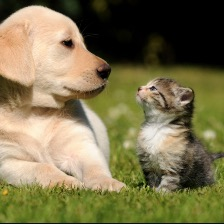
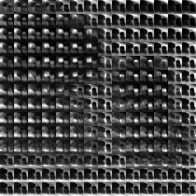

In [27]:
lucid_svelte.CossimOverlay({
    "image_url": _image_url(img),
    "masks_url": _image_url(cossims_flat),
    "size": 224,
    "N": cossims.shape[0]
})

In [28]:
%%html_define_svelte CossimOverlayMulti


{{#each range(n_images) as n_img}}
<div class="container" style="width: {{size}}px; height: {{size}}px; float: left; margin: 5px;">
  <!--div class="image" style="background-image: url({{image_urls[n_img]}}); z-index: -10; width: {{size}}px; height: {{size}}px;"></div-->
  <div class="overlay" style="z-index: 10; width: {{size}}px; height: {{size}}px; left:{{size/2-N/2}}px; top:{{size/2-N/2}}px;">
    <div class="image" style="background-image: url({{image_urls[n_img]}}); width: {{size}}px; height: {{size}}px; left:-{{size/2-N/2}}px; top:-{{size/2-N/2}}px;"></div>
    <div class="overlay-inner" style="width: {{N}}px; height: {{N}}px; transform: scale({{size/N}}); background-image: url({{(pos == undefined)? '' : masks_urls[pos[0]][n_img]}});  background-position: {{(pos == undefined)? '' : -pos[1]*N}}px {{(pos == undefined)? '' : -pos[2]*N}}px; opacity: 0.7;">
    </div>
  </div>
  <div class="event-catcher" 
       style="z-index: 20; width: {{size}}px; height: {{size}}px;"
       on:mousemove="set({pos: [n_img, Math.floor(N*event.offsetX/size), Math.floor(N*event.offsetY/size)]})"
       on:mouseout="set({pos: undefined})"
       ></div>
</div>
{{/each}}

<br style="clear: both;">

<div>{{pos}}</div>

<style>
  .container {
    position: relative;
  }
  .image, .overlay, .event-catcher {
    position: absolute;
    left: 0px;
    top: 0px;
  }
  .overlay-inner {
    image-rendering: pixelated;
  }
</style>

<script>

  function range(n){
    return Array(n).fill().map((_, i) => i);
  }
  
  
  export default {
    data () {
      return {
        image_urls: undefined,
        size: undefined,
        N: undefined,
        n_images: undefined,
        masks_urls: undefined,
        pos: undefined,
      };
    },
    computed: {
    },
    helpers: {range}
  };
</script>

Trying to build svelte component from html...
svelte compile --format iife /var/folders/qp/bv6306h114v0nq53zsvdxt1h0000gn/T/svelte_bv4m3ev5/CossimOverlayMulti_0e6176fc_8441_43f6_b262_d6eecb40a0f6.html > /var/folders/qp/bv6306h114v0nq53zsvdxt1h0000gn/T/svelte_bv4m3ev5/CossimOverlayMulti_0e6176fc_8441_43f6_b262_d6eecb40a0f6.js
b'svelte version 1.64.1\ncompiling ../../../../../../../var/folders/qp/bv6306h114v0nq53zsvdxt1h0000gn/T/svelte_bv4m3ev5/CossimOverlayMulti_0e6176fc_8441_43f6_b262_d6eecb40a0f6.html...\n'


In [29]:
#img_urls = ["https://storage.googleapis.com/lucid-static/building-blocks/examples/dog_cat.png",
#            "https://storage.googleapis.com/lucid-static/building-blocks/examples/flowers.png",
#            "https://storage.googleapis.com/lucid-static/building-blocks/examples/pig.jpeg"]
img_urls = ["https://github.com/ercaronte/lucid/raw/master/notebooks/static/dogcat.jpg",
            "https://github.com/ercaronte/lucid/raw/master/notebooks/static/flowers.jpeg",
            "https://github.com/ercaronte/lucid/raw/master/notebooks/static/pig.jpeg"]
imgs = [load(url) for url in img_urls]
acts_ = [get_acts("mixed4d", img) for img in imgs]
grids = [[np.hstack(np.hstack(cossim_grid(acts1, acts2)))
          for acts2 in acts_] for acts1 in acts_]


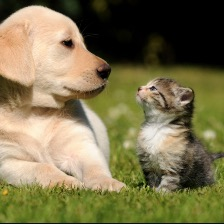
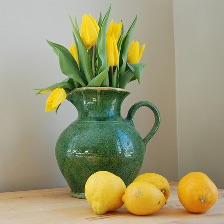
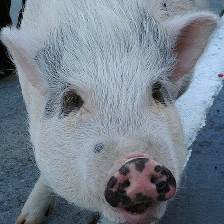
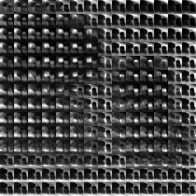
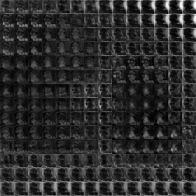
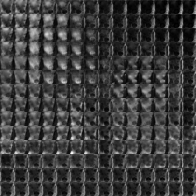
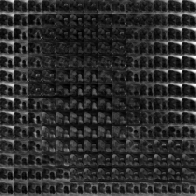
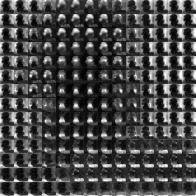
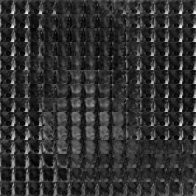
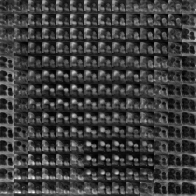
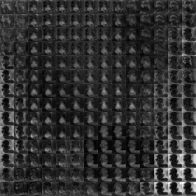
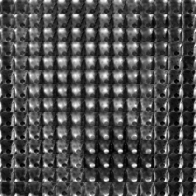

In [30]:
lucid_svelte.CossimOverlayMulti({
    "image_urls": [_image_url(img) for img in imgs],
    "masks_urls": [[_image_url(cossims_flat) for cossims_flat in row] for row in grids],
    "size": 224,
    "N": cossims.shape[0],
    "n_images": len(imgs),
})

In [31]:
#img_urls = ["https://storage.googleapis.com/lucid-static/building-blocks/examples/dog_cat.png",
#            "https://storage.googleapis.com/lucid-static/building-blocks/examples/flowers.png",
#            "https://storage.googleapis.com/lucid-static/building-blocks/examples/pig.jpeg"]
img_urls = ["https://github.com/ercaronte/lucid/raw/master/notebooks/static/dogcat.jpg",
            "https://github.com/ercaronte/lucid/raw/master/notebooks/static/flowers.jpeg",
            "https://github.com/ercaronte/lucid/raw/master/notebooks/static/pig.jpeg"]
imgs = [load(url) for url in img_urls]
acts_ = [get_acts("mixed4a", img) for img in imgs]
grids = [[np.hstack(np.hstack(cossim_grid(acts1, acts2)))
          for acts2 in acts_] for acts1 in acts_]


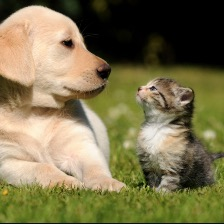
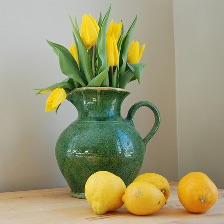
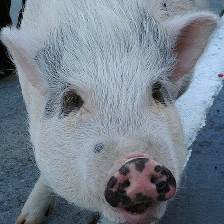
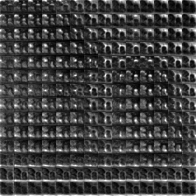
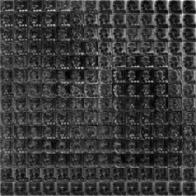
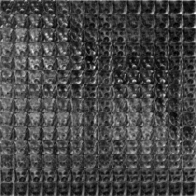
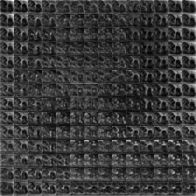
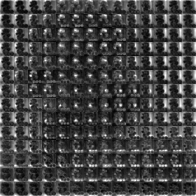
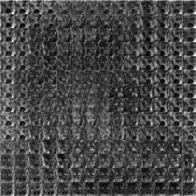
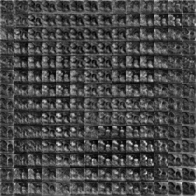
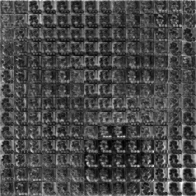
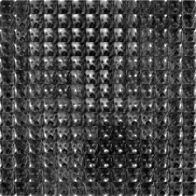

In [32]:
lucid_svelte.CossimOverlayMulti({
    "image_urls": [_image_url(img) for img in imgs],
    "masks_urls": [[_image_url(cossims_flat) for cossims_flat in row] for row in grids],
    "size": 224,
    "N": acts_[0].shape[1],
    "n_images": len(imgs),
})